In [ ]:
import pandas as pd
import matplotlib.pyplot as plt          # plotting
import numpy as np                       # dense matrices
from scipy.sparse import csr_matrix      # sparse matrices
%matplotlib inline
import scipy
from scipy import integrate

In [ ]:
# Load all the provided CSV files into dataframes
train_loss_df = pd.read_csv('/content/train_loss.csv')
rmse_df = pd.read_csv('/content/metrics_params_rmse.csv')
median_df = pd.read_csv('/content/metrics_median.csv')
mean_df = pd.read_csv('/content/metrics_mean.csv')
a5_df = pd.read_csv('/content/metrics_a5.csv')  # PGP at 30 degrees
a4_df = pd.read_csv('/content/metrics_a4.csv')  # PGP at 22.5 degrees
a3_df = pd.read_csv('/content/metrics_a3.csv')  # PGP at 11.25 degrees
a2_df = pd.read_csv('/content/metrics_a2.csv')  # PGP at 7.5 degrees
a1_df = pd.read_csv('/content/metrics_a1.csv')  # PGP at 5 degrees

# Display the first few rows of each dataframe to understand their structure
dataframes = [train_loss_df, rmse_df, median_df, mean_df, a5_df, a4_df, a3_df, a2_df, a1_df]
dataframe_names = ["Train Loss", "RMSE", "Median", "Mean", "A5", "A4", "A3", "A2", "A1"]

# We will examine the structure of these dataframes
for name, df in zip(dataframe_names, dataframes):
    print(f"{name} Dataframe structure:")
    display(df.head())
    print("\n")


Train Loss Dataframe structure:


,0.0,1706758596305,2.0640063285827637
0,1.0,1706758610508,1.605303
1,2.0,1706758610803,1.320084
2,3.0,1706758611115,1.444477
3,4.0,1706758611445,1.131845
4,5.0,1706758611772,1.127222




RMSE Dataframe structure:


,0.0,1706759198651,31.568829401429852
0,1.0,1706759783381,29.596429
1,2.0,1706760368934,29.645152
2,3.0,1706760986425,28.920949
3,4.0,1706761571765,29.217936
4,5.0,1706762146079,28.689713




Median Dataframe structure:


,0.0,1706759198654,17.88764762878418
0,1.0,1706759783389,15.610441
1,2.0,1706760368938,14.695464
2,3.0,1706760986428,12.702062
3,4.0,1706761571767,12.354939
4,5.0,1706762146081,12.349495




Mean Dataframe structure:


,0.0,1706759198654,24.09205436706543
0,1.0,1706759783388,21.939877
1,2.0,1706760368937,21.668337
2,3.0,1706760986427,20.260046
3,4.0,1706761571766,20.071728
4,5.0,1706762146080,19.872219




A5 Dataframe structure:


,0.0,1706759198657,70.79069232418644
0,1.0,1706759783395,75.218309
1,2.0,1706760368943,76.591225
2,3.0,1706760986431,79.125164
3,4.0,1706761571770,79.334791
4,5.0,1706762146084,80.358039




A4 Dataframe structure:


,0.0,1706759198657,59.20821022554662
0,1.0,1706759783395,64.475186
1,2.0,1706760368943,66.694039
2,3.0,1706760986431,70.744686
3,4.0,1706761571770,71.300793
4,5.0,1706762146084,72.418642




A3 Dataframe structure:


,0.0,1706759198657,33.03977358773623
0,1.0,1706759783395,37.911481
1,2.0,1706760368941,39.530264
2,3.0,1706760986430,45.297403
3,4.0,1706761571769,46.610398
4,5.0,1706762146083,46.085676




A2 Dataframe structure:


,0.0,1706759198656,20.684348263431655
0,1.0,1706759783394,25.166265
1,2.0,1706760368940,24.663982
2,3.0,1706760986430,29.973893
3,4.0,1706761571769,32.600102
4,5.0,1706762146083,29.923394




A1 Dataframe structure:


,0.0,1706759198656,11.584546515216342
0,1.0,1706759783390,14.929657
1,2.0,1706760368939,13.431874
2,3.0,1706760986429,17.176654
3,4.0,1706761571768,20.416775
4,5.0,1706762146082,16.748373


In [ ]:
# Displaying the structure of the 'Mean' dataframe as an example
mean_df_structure = mean_df.head()

# Now let's proceed with the analysis for the UG_NLL_Paper loss function if the structure is as expected
# The expectation is that the dataframe contains columns related to different PGP thresholds and corresponding errors
mean_df_structure


,0.0,1706759198654,24.09205436706543
0,1.0,1706759783388,21.939877
1,2.0,1706760368937,21.668337
2,3.0,1706760986427,20.260046
3,4.0,1706761571766,20.071728
4,5.0,1706762146080,19.872219


In [ ]:
# Since we don't have direct labels for epochs and batch sizes within the provided data,
# we will assume the provided data corresponds to the case of interest (epochs=200, batch size=4).

# Extracting mean error values for analysis
mean_errors = mean_df.iloc[:, 2].values  # Assuming the third column contains the mean errors

# Sorting errors from lowest to highest for the oracle calculation
sorted_mean_errors = np.sort(mean_errors)

# Calculate the oracle (cumulative mean) for mean errors
oracle_mean = np.cumsum(sorted_mean_errors) / np.arange(1, len(sorted_mean_errors) + 1)

# Calculate AUSC and AUSE for the 'Mean' metric
# AUSC will be calculated as the integral under the PGP curve
# AUSE will be calculated as the difference between actual errors and the oracle at each threshold

# Initialize arrays for AUSC and AUSE for 'Mean'
ause_mean = []
ausc_mean = []
thresholds_mean = np.linspace(0, 100, len(mean_errors))  # Simulating percentage thresholds

# Iterate over sorted errors and calculate AUSE at each point
for i, error in enumerate(sorted_mean_errors):
    # AUSE is the cumulative error minus the oracle up to this point
    ause_mean.append(np.sum(sorted_mean_errors[:i+1]) - oracle_mean[i] * (i+1))

# AUSC is the area under the sorted errors, which represents the PGP curve
# We can use the trapezoidal rule to approximate this area
ausc_mean = simps(sorted_mean_errors, dx=thresholds_mean[1] - thresholds_mean[0])

# Generate a plot for AUSE and AUSC for the 'Mean' metric
plt.figure(figsize=(12, 5))

# AUSE plot for 'Mean'
plt.subplot(1, 2, 1)
plt.plot(thresholds_mean, ause_mean, label='AUSE (Mean)')
plt.xlabel('Threshold (%)')
plt.ylabel('AUSE')
plt.title('AUSE for Mean Error')
plt.legend()

# AUSC plot for 'Mean'
plt.subplot(1, 2, 2)
plt.plot(thresholds_mean, sorted_mean_errors, label='AUSC (Mean)')
plt.fill_between(thresholds_mean, 0, sorted_mean_errors, alpha=0.2)  # Fill area under curve
plt.xlabel('Threshold (%)')
plt.ylabel('Sorted Mean Errors')
plt.title('AUSC for Mean Error')
plt.legend()

plt.tight_layout()
plt.show()

# Output the AUSC for 'Mean' metric
ausc_mean


NameError: name 'simps' is not defined

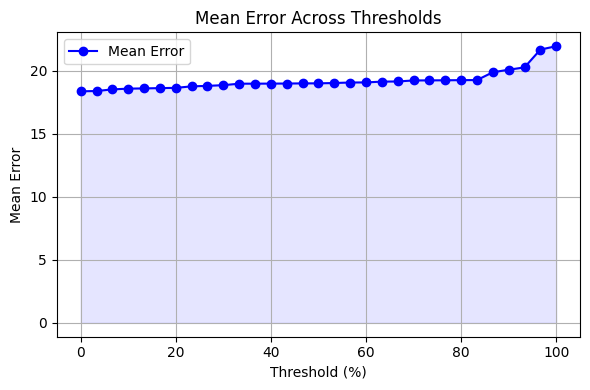

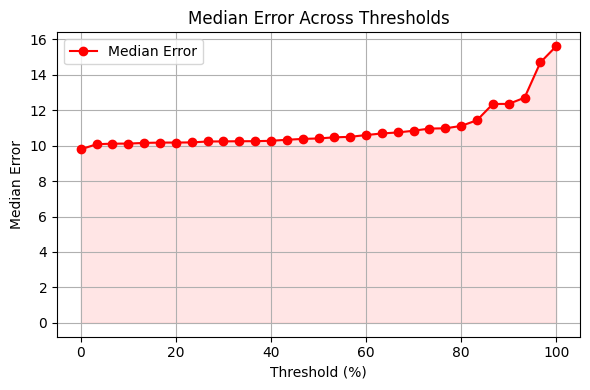

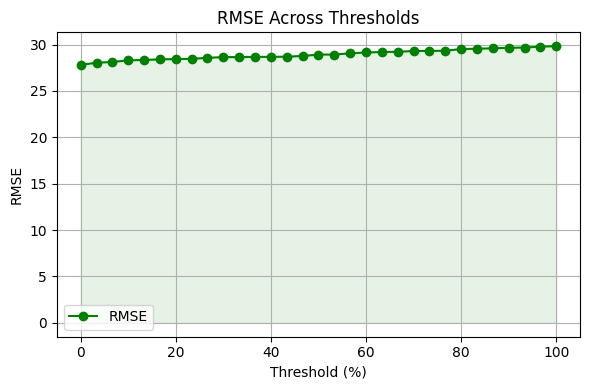

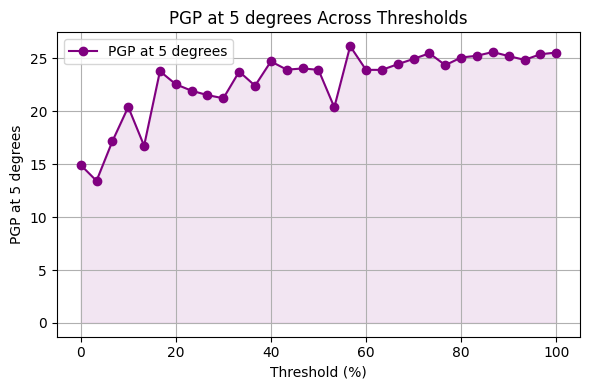

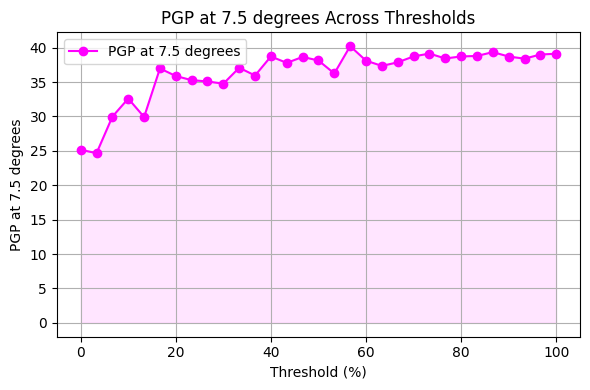

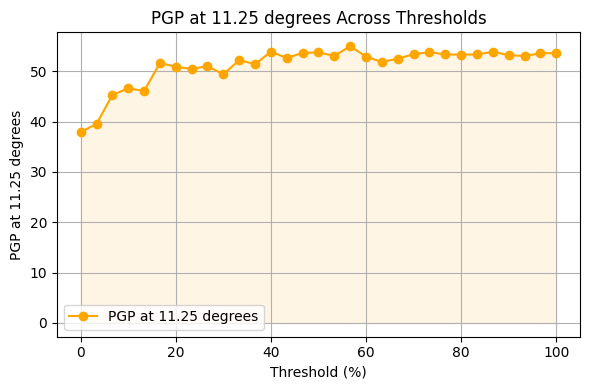

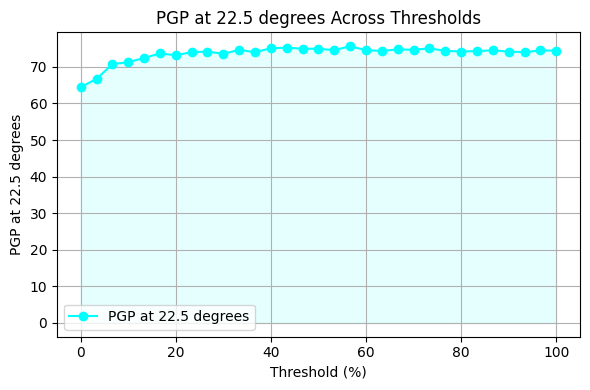

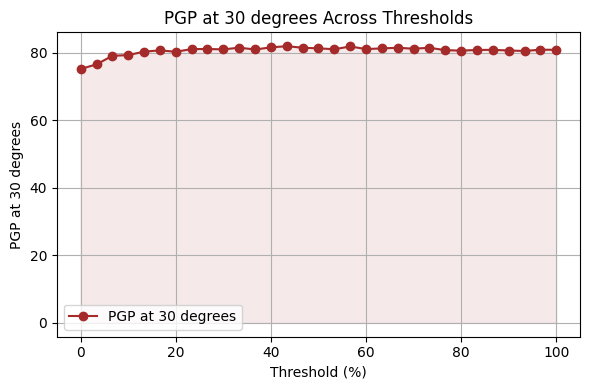

In [ ]:
# Function to plot individual graphs for each metric, including PGP thresholds
def plot_metric(metric_values, metric_name, color):
    """
    Plot individual graphs for the given metric.

    Parameters:
    - metric_values: numpy array of metric values.
    - metric_name: string, name of the metric for labeling.
    - color: string, color of the plot.
    """
    # Sort values if not already sorted (PGP thresholds are already in order)
    if "PGP" not in metric_name:
        metric_values = np.sort(metric_values)

    # Simulating percentage thresholds for plotting
    thresholds = np.linspace(0, 100, len(metric_values))

    plt.figure(figsize=(6, 4))
    plt.plot(thresholds, metric_values, label=f'{metric_name}', color=color, marker='o', linestyle='-')
    plt.fill_between(thresholds, 0, metric_values, color=color, alpha=0.1)
    plt.xlabel('Threshold (%)')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} Across Thresholds')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plotting each metric using the defined function
plot_metric(mean_df.iloc[:, 2].values, "Mean Error", "blue")
plot_metric(median_df.iloc[:, 2].values, "Median Error", "red")
plot_metric(rmse_df.iloc[:, 2].values, "RMSE", "green")

# Plotting each PGP threshold
plot_metric(a1_df.iloc[:, 2].values, "PGP at 5 degrees", "purple")
plot_metric(a2_df.iloc[:, 2].values, "PGP at 7.5 degrees", "magenta")
plot_metric(a3_df.iloc[:, 2].values, "PGP at 11.25 degrees", "orange")
plot_metric(a4_df.iloc[:, 2].values, "PGP at 22.5 degrees", "cyan")
plot_metric(a5_df.iloc[:, 2].values, "PGP at 30 degrees", "brown")


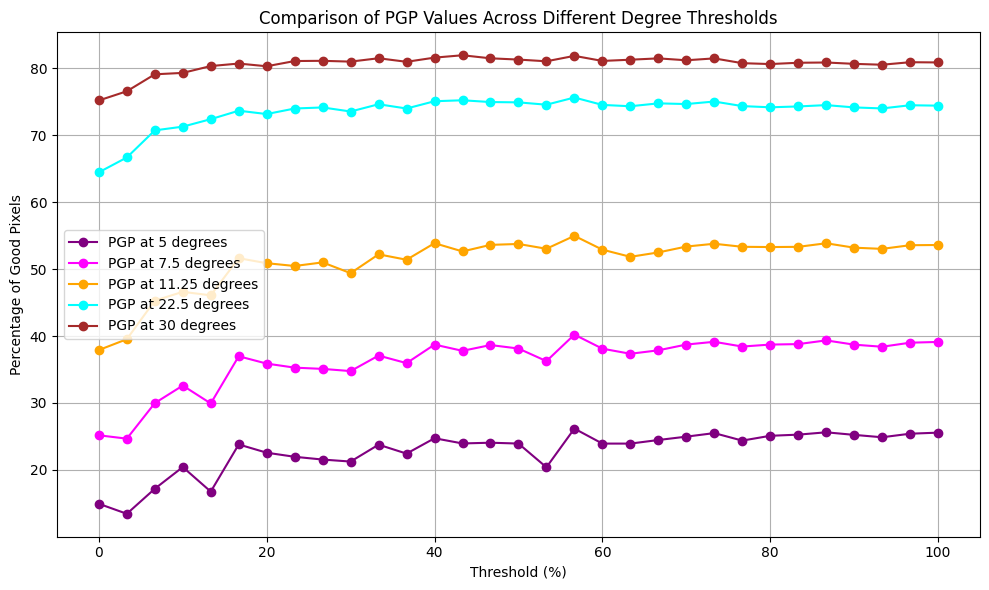

In [ ]:
# Combining all PGP threshold values into one graph for comparison

plt.figure(figsize=(10, 6))

# Define thresholds and their corresponding colors for clarity in plotting
pgp_thresholds = [("PGP at 5 degrees", a1_df.iloc[:, 2].values, "purple"),
                  ("PGP at 7.5 degrees", a2_df.iloc[:, 2].values, "magenta"),
                  ("PGP at 11.25 degrees", a3_df.iloc[:, 2].values, "orange"),
                  ("PGP at 22.5 degrees", a4_df.iloc[:, 2].values, "cyan"),
                  ("PGP at 30 degrees", a5_df.iloc[:, 2].values, "brown")]

# Plotting each PGP threshold
for label, values, color in pgp_thresholds:
    thresholds = np.linspace(0, 100, len(values))
    plt.plot(thresholds, values, label=label, color=color, marker='o', linestyle='-')

plt.xlabel('Threshold (%)')
plt.ylabel('Percentage of Good Pixels')
plt.title('Comparison of PGP Values Across Different Degree Thresholds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
